## Preliminaries
Imports, setup, etc.

In [1]:
from scipy.io import wavfile
import soundfile
import glob
import types
import numpy as np



## Load sound files

In [2]:
flac_files = glob.glob('*.FLAC')
sounds = []
for filename in flac_files:
    d, sr = soundfile.read(filename)
    sounds.append(types.SimpleNamespace(filename=filename, data=d, samplerate=sr, start=0, end=-1))

print(sounds)

[namespace(data=array([-1.32679939e-04, -1.31368637e-04, -1.38759613e-04, ...,
       -9.89437103e-06, -1.13248825e-05, -1.15633011e-05]), end=-1, filename='LM.FLAC', samplerate=48000, start=0), namespace(data=array([-4.19616699e-05, -3.39746475e-05, -3.80277634e-05, ...,
       -2.65836716e-05, -1.39474869e-05, -2.37226486e-05]), end=-1, filename='OR.FLAC', samplerate=48000, start=0), namespace(data=array([0.00289333, 0.0021379 , 0.00128698, ..., 0.00011492, 0.00011015,
       0.00012565]), end=-1, filename='16b.FLAC', samplerate=48000, start=0), namespace(data=array([ 3.09944153e-06, -7.51018524e-06,  3.76701355e-05, ...,
        4.76837158e-06,  2.62260437e-06,  5.36441803e-06]), end=-1, filename='30b.FLAC', samplerate=48000, start=0), namespace(data=array([6.43730164e-06, 1.56164169e-05, 1.54972076e-05, ...,
       5.75780869e-05, 7.14063644e-05, 7.91549683e-05]), end=-1, filename='30s.FLAC', samplerate=48000, start=0), namespace(data=array([6.02006912e-05, 5.87701797e-05, 6.008148

## Preprocessing

Several things are done to massage the signals:
* Remove any DC offset.
* Find the useful portion of the signal. Specifically, trim slience (signal below NOISE_THESHOLD_RATIO of max) from either end of the file. 
* Normalize audio across files. Currently normalized based on the rms of a file vs the max rms of all files.


In [3]:
# Preprocessing

# Remove DC offset using a narrow notch filter
# From https://stackoverflow.com/questions/6994020/remove-unknown-dc-offset-from-a-non-periodic-discrete-time-signal
import scipy.signal

a = [1 , -0.98]; b = [1,-1];
for s in sounds:
    s.data = scipy.signal.filtfilt(b,a,s.data);

NOISE_THRESHOLD_RATIO = 0.05

def find_start_end(data):
    '''
    Effectively trims the given audio data by returning start and end indices for the portion of the 
    audio that is above NOISE_THRESHOLD_RATIO * maximum sample in the data.
    '''
    def i_beyond_threshold(data, noise_threshold):
        '''
        Return the index of the first sample whose abs() > noise_threshold.
        '''
        start = 0
        for i,s in enumerate(data):
            if abs(s) > noise_threshold:
                start = i
                break
        return start
    
    def i_next_crossing(data):
        '''
        Return the index of the sample that crosses the origin (i.e. changes sign).
        '''
        last_val = 0.
        i_crossing = 0
        for i,s in enumerate(data):
            if s * last_val < 0:
                # there was a sign change, thus we crossed the axis
                i_crossing = i
                break
            else:
                last_val = s
        return i_crossing
    
    noise_threshold = max(data) * NOISE_THRESHOLD_RATIO
    print(f'noise = {noise_threshold}')
    # Find the beginning of the sound that goes beyond the noise threshold
    # Then tune it to the first crossing of the axis
    start = i_beyond_threshold(data, noise_threshold)
    start += i_next_crossing(data[start:])
    # Similarly, but reverse for the end of the sound
    end = data.shape[0] - i_beyond_threshold(reversed(data), noise_threshold)
    end -= i_next_crossing(reversed(data[:end]))
    return (start, end)

# Find section of file that contains interesting sound
for s in sounds:
    s.start, s.end = find_start_end(s.data)
    # Fudge start ahead 4 seconds because these samples start to get more consistent then.
    # NOTE: if you do this, then you can use height=s.rms in the peak finder below.
    # s.start += 4 * s.samplerate
    slc = s.data[s.start:s.end]
    s.max = np.max(np.absolute(slc))
    s.rms = np.sqrt(np.mean(slc**2))
    print(f'max = {np.max(slc)}; min = {np.min(slc)}')

max_max = max([s.max for s in sounds])
max_rms = max([s.rms for s in sounds])
print(f'max_max = {max_max}, max_rms = {max_rms}')

# normalize
for s in sounds:
    s.normalized = max_rms / s.rms * s.data



noise = 0.014230843584202091


NameError: name 'np' is not defined

## Peak finding

This finds the first peak in the signal after s.start, found above. The idea is to effectively synch all signals on a peak so that we're looking at as much of the same thing as possible.

This uses the peak finder in scipy. For the height threshold, we can either use s.rms, or s.max * MAX_THRESHOLD. Trying both out, it seems that s.rms is ~ 10% the magnitude of s.max, so it picks up peaks quite quickly, often in the early part of the signal before the transients in the start of the note have died out. So, we only use s.rms if we fudge the start in code above to start some arbitrary amount of time into the note (e.g. 4 sec). It seems, though, that using s.max * MAX_THRESHOLD starts finding peaks much later in the signal automatically, so we just use that.

In [19]:
# find a peak to sync on
MAX_THRESHOLD = 0.8
SKIP_TIME = 1 # seconds; the amount of time from the beginning of the signal to start actually paying attention.

for s in sounds:
    # start = s.start + SKIP_TIME * s.samplerate
    start = s.start
    # TODO: Which is the appropriate height threshold?
    # peaks,props = scipy.signal.find_peaks(s.data[start:s.end], height=s.rms)
    peaks,props = scipy.signal.find_peaks(s.data[start:s.end], height=s.max * MAX_THRESHOLD)
    print(s.rms, s.max)
    s.peak_start = peaks[0] + s.start
    print(f's.peak_start={s.peak_start}')


0.06425764082258525 0.21479717313798477
s.peak_start=530375
0.06967973444553795 0.22564097539575917
s.peak_start=539464
0.06549842158617175 0.21809478567964333
s.peak_start=517040
0.07378334961919497 0.2453789273617114
s.peak_start=511372
0.06881197943176041 0.21698939008984353
s.peak_start=568753
0.06603565788853484 0.20733265682414298
s.peak_start=598774


## Show preliminary results

### Handy functions for plotting and playing files (play doesn't work over the web)

In [2]:
# from https://docs.scipy.org/doc/scipy/reference/generated/scipy.io.wavfile.read.html

import matplotlib.pyplot as plt

def plot_wav(data, samplerate, start=0, end=-1, title=None, data2=None):
    plt.figure(figsize=(15,4))
    slc = data[start:end]
    length = slc.shape[0] / samplerate
    time = np.linspace(0., length, slc.shape[0])
    if len(slc.shape) == 1:
        plt.plot(time, slc, label="Mono channel")
    else:
        plt.plot(time, slc[:, 0], label="Left channel")
        plt.plot(time, slc[:, 1], label="Right channel")
    if data2 is not None:
        slc2 = data2[start:end]
        if len(slc2.shape) == 1:
            plt.plot(time, slc2, label="Data 2 Mono channel")
        else:
            plt.plot(time, slc2[:, 0], label="Data 2 Left channel")
            plt.plot(time, slc2[:, 1], label="Data 2 Right channel")
    if title is not None:
        plt.title(title)
    plt.legend()
    plt.xlabel("Time [s]")
    plt.ylabel("Amplitude")
    plt.axhline(y=0, color='k')
    plt.show()

import sounddevice
def play(data, samplerate, wait_for_end=True):
    audio = (data*32768).astype(np.int16)
    sounddevice.play(audio, samplerate)
    if wait_for_end:
        sounddevice.wait()
    

## Show me the data

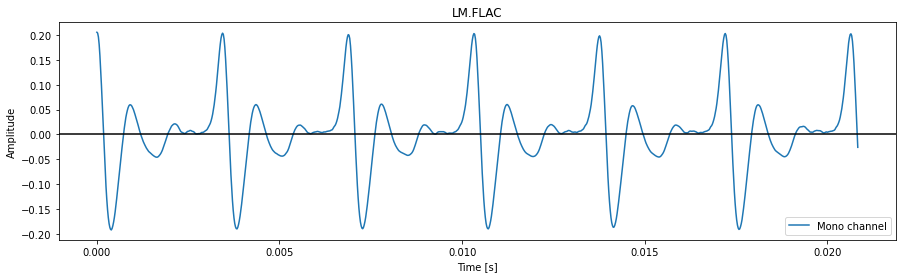

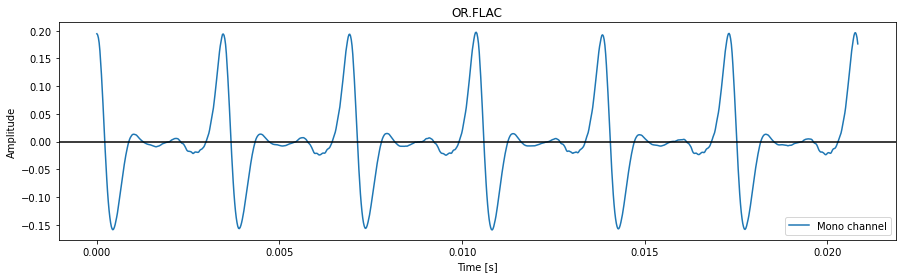

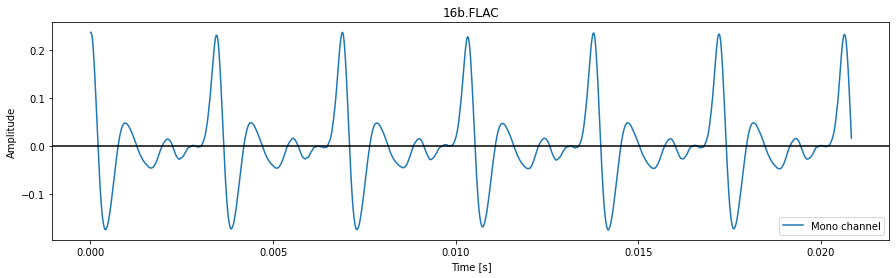

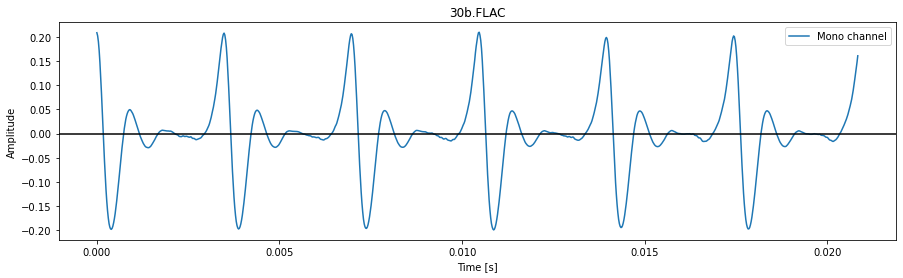

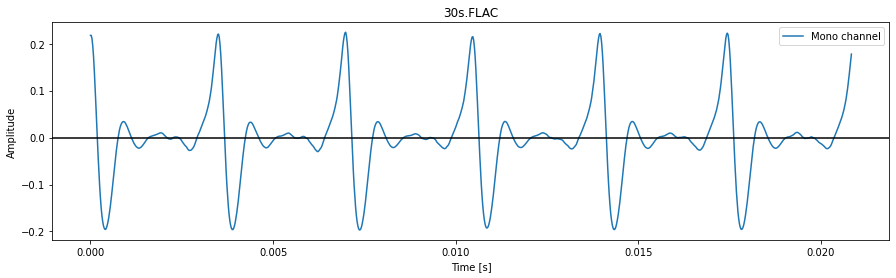

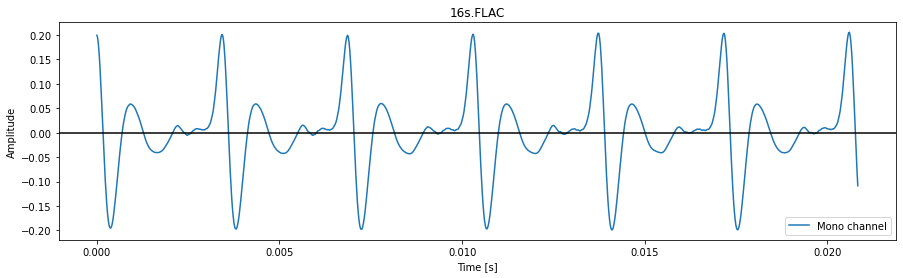

In [20]:
for s in sounds:
    # plot_wav(s.normalized, s.samplerate, s.start+s.samplerate, s.start+s.samplerate+500, s.filename)
    plot_wav(s.normalized, s.samplerate, s.peak_start, s.peak_start + 1000, s.filename)
    # play(s.normalized[s.start:s.end], s.samplerate)